# Introduction
---
In this assignment, we will try to find the best model for a given dataset.
We will perform the following stages:
1. Import the data
2. Preliminary data analysis
3. Preprocessing
4. Trying different models
5. Balancing the data
6. Grid search for the best hyperparameters

We will choose between the following classification models __learned in class so far__:
- Logistic Regression
- Decision Tree
- Random Forest
- AdaBoost
- Gradient Boosting
- XGBoost

In [69]:
import pickle
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb
from sklearn.model_selection import KFold, GridSearchCV
import statistics
from sklearn.base import clone
from collections import Counter
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from imblearn.over_sampling import RandomOverSampler

In [70]:
# connect google drive to the colab

from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive


In [74]:
with open('ass2.pickle', 'rb') as f:
    data = pickle.load(f)

# 1. Import the Data set
---

In [72]:
## Load the data
with open('../../data/ass2.pickle', 'rb') as f:
    data = pickle.load(f)

FileNotFoundError: ignored

In [75]:
## Example of train samples
df = pd.DataFrame(data['train'])
df.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f33,f34,f35,f36,f37,f38,f39,f40,f41,target
51905,1,0,0,0,0,0,2,1,2,2,...,0,0,0,2,0,0,0,0,0,2
52612,0,0,0,0,0,0,2,1,0,0,...,0,0,0,2,0,0,0,0,0,2
61699,2,1,2,1,1,0,2,2,0,0,...,0,0,0,1,0,0,0,0,0,2
6291,0,0,0,0,0,0,0,0,0,0,...,0,0,0,2,0,0,0,0,0,2
17484,0,0,0,0,0,0,1,1,2,0,...,0,0,0,2,1,2,0,0,0,2


#### Extract train, dev, test datasets (x and y)

In [76]:
## Get train dev test Xs and ys (X type is dataFrame and y type is Series)
df_train = data['train']
X_train = df_train.iloc[:, :-1]
y_train = df_train.iloc[:, -1]

df_dev = data['dev']
X_dev = df_dev.iloc[:, :-1]
y_dev = df_dev.iloc[:, -1]

df_test = data['test']
X_test = df_test.iloc[:, :-1]
y_test = df_test.iloc[:, -1]

# 2. Preliminary data analysis
---
In this section, we will analyze the data and try to understand it better.
We will focus on the following:
- What is the problem type? (classification/regression)
- What is the data distribution?
- What is the data range?
- Are there missing values?
- What is the correlation between the features?
- What is the correlation between each feature and the label?
- What is the distribution of each feature?

In [77]:
print(f"X_train shape: {X_train.shape}")
print(f"X_dev shape: {X_dev.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (40533, 42)
X_dev shape: (13512, 42)
X_test shape: (13512, 42)


In [78]:
# count the number of samples for each label in the train dataset
print(f"Distribution of labels in the train dataset, order from most common to least: {list(Counter(y_train).items())}")

Distribution of labels in the train dataset, order from most common to least: [(2, 26734), (1, 9882), (0, 3917)]


#### We can see that this is a classification problem and that the train data is not well-balanced, there are significantly more 2s than 1s or 0s

In [79]:
# check samples values range
print(f"X_train values range: {X_train.min().min()} - {X_train.max().max()}")

X_train values range: 0 - 2


In [80]:
# check if there are missing values
print(f"Number of missing values in the train dataset: {X_train.isnull().sum().sum()}")

Number of missing values in the train dataset: 0


#### there are no missing values and the possible values of each feature are between options 0, 1 and 2

<Axes: >

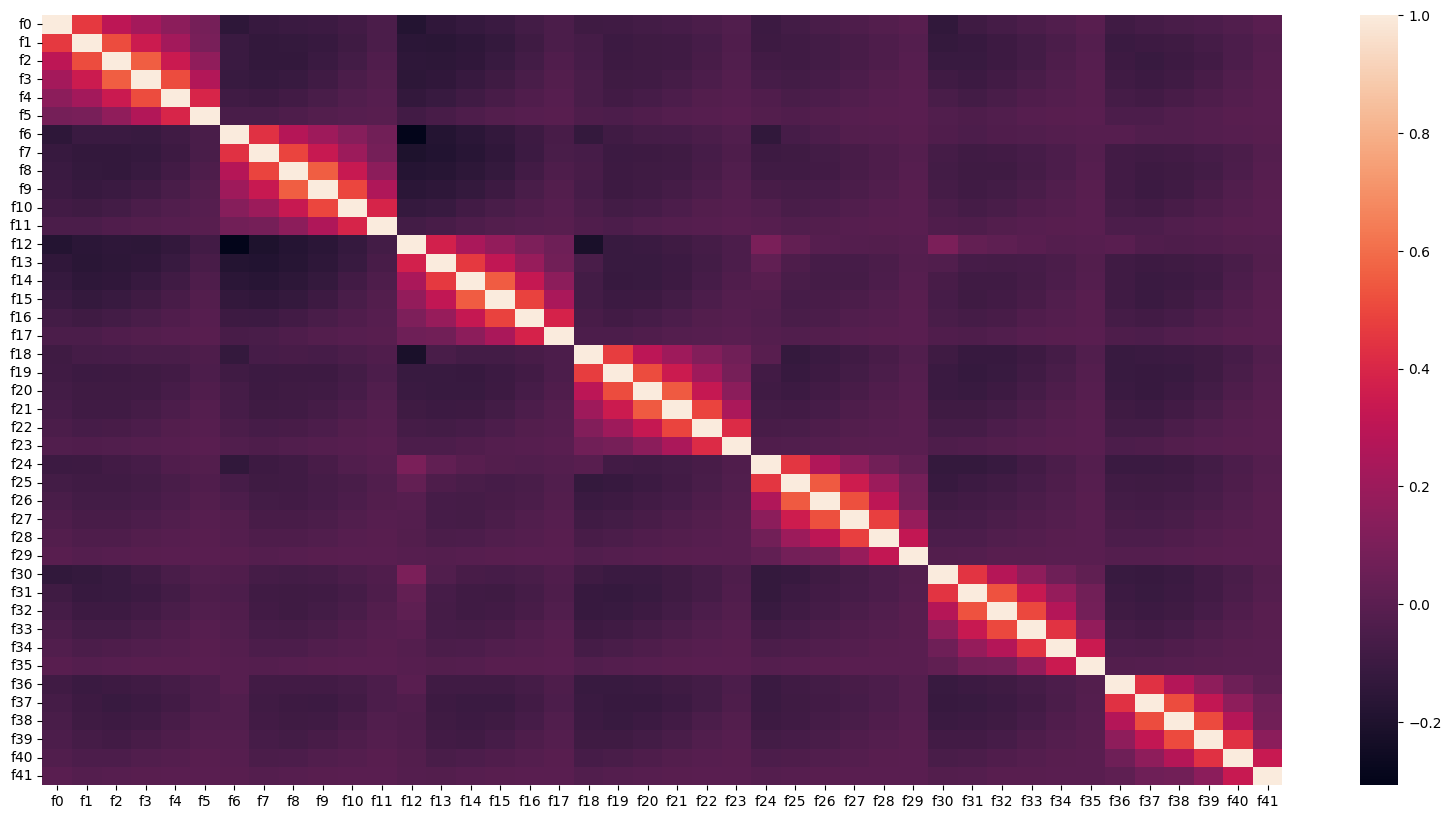

In [81]:
plt.figure(figsize=(20, 10))
# check correlation between features
sns.heatmap(X_train.corr())

#### There is no apparent correlation between any two features that we can observe

In [82]:
def plot_feature_label_correlation(X: pd.DataFrame, y: pd.Series):
    # show correlation between each feature and the label
    all_correlations = []
    for col in X.columns:
        corr = X[col].corr(y)
        all_correlations.append(corr)
    # plot the correlation between each feature and the label
    plt.figure(figsize=(20, 10))
    # add a horizontal line at 0.01 and -0.01
    plt.axhline(y=0.01, color='r', linestyle='-')
    plt.axhline(y=-0.01, color='r', linestyle='-')
    plt.yticks([-0.075, -00.5, -0.025, -0.01, 0, 0.01, 0.025, 0.05, 0.075])

    # add title and labels
    plt.title('Correlation between each feature and the label')
    plt.xlabel('Features')
    plt.ylabel('Correlation')
    # plot the barplot
    sns.barplot(x=X.columns, y=all_correlations)
    return all_correlations


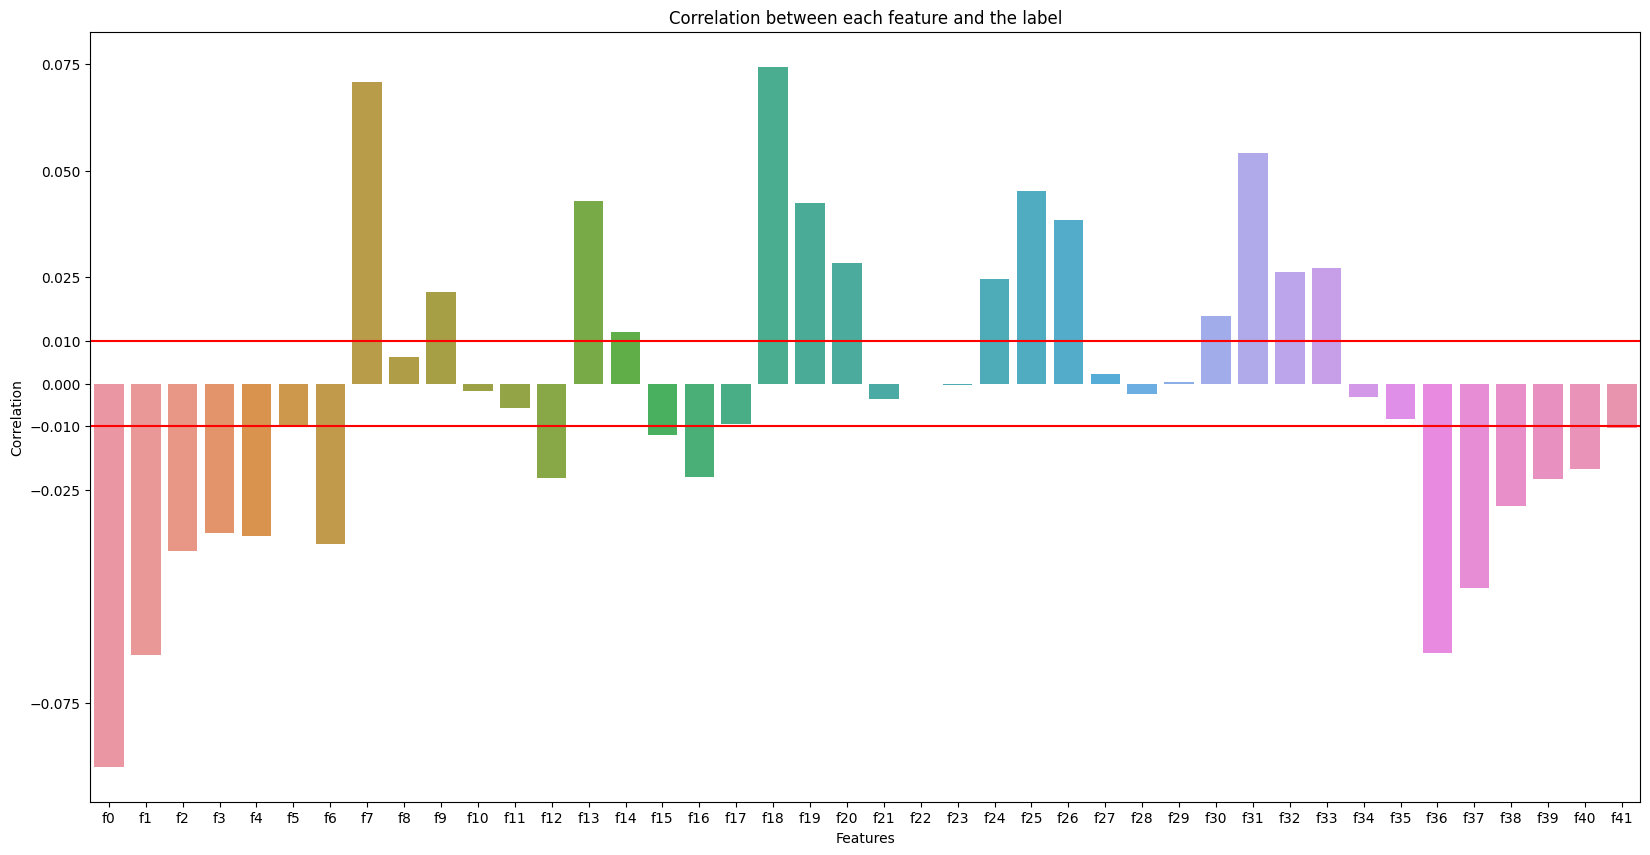

In [83]:
# show correlation between each feature and the label
correlations = plot_feature_label_correlation(X_train, y_train)

##### We can see that there is no direct correlation between a single feature and the label because all values are between -0.1 and 0.1, not even close to 1 or -1
Yet we can still learn from this graph that there are some features that are a bit more correlated with the label than others, __we can reduce the number of features by removing the ones that are not correlated at all.__

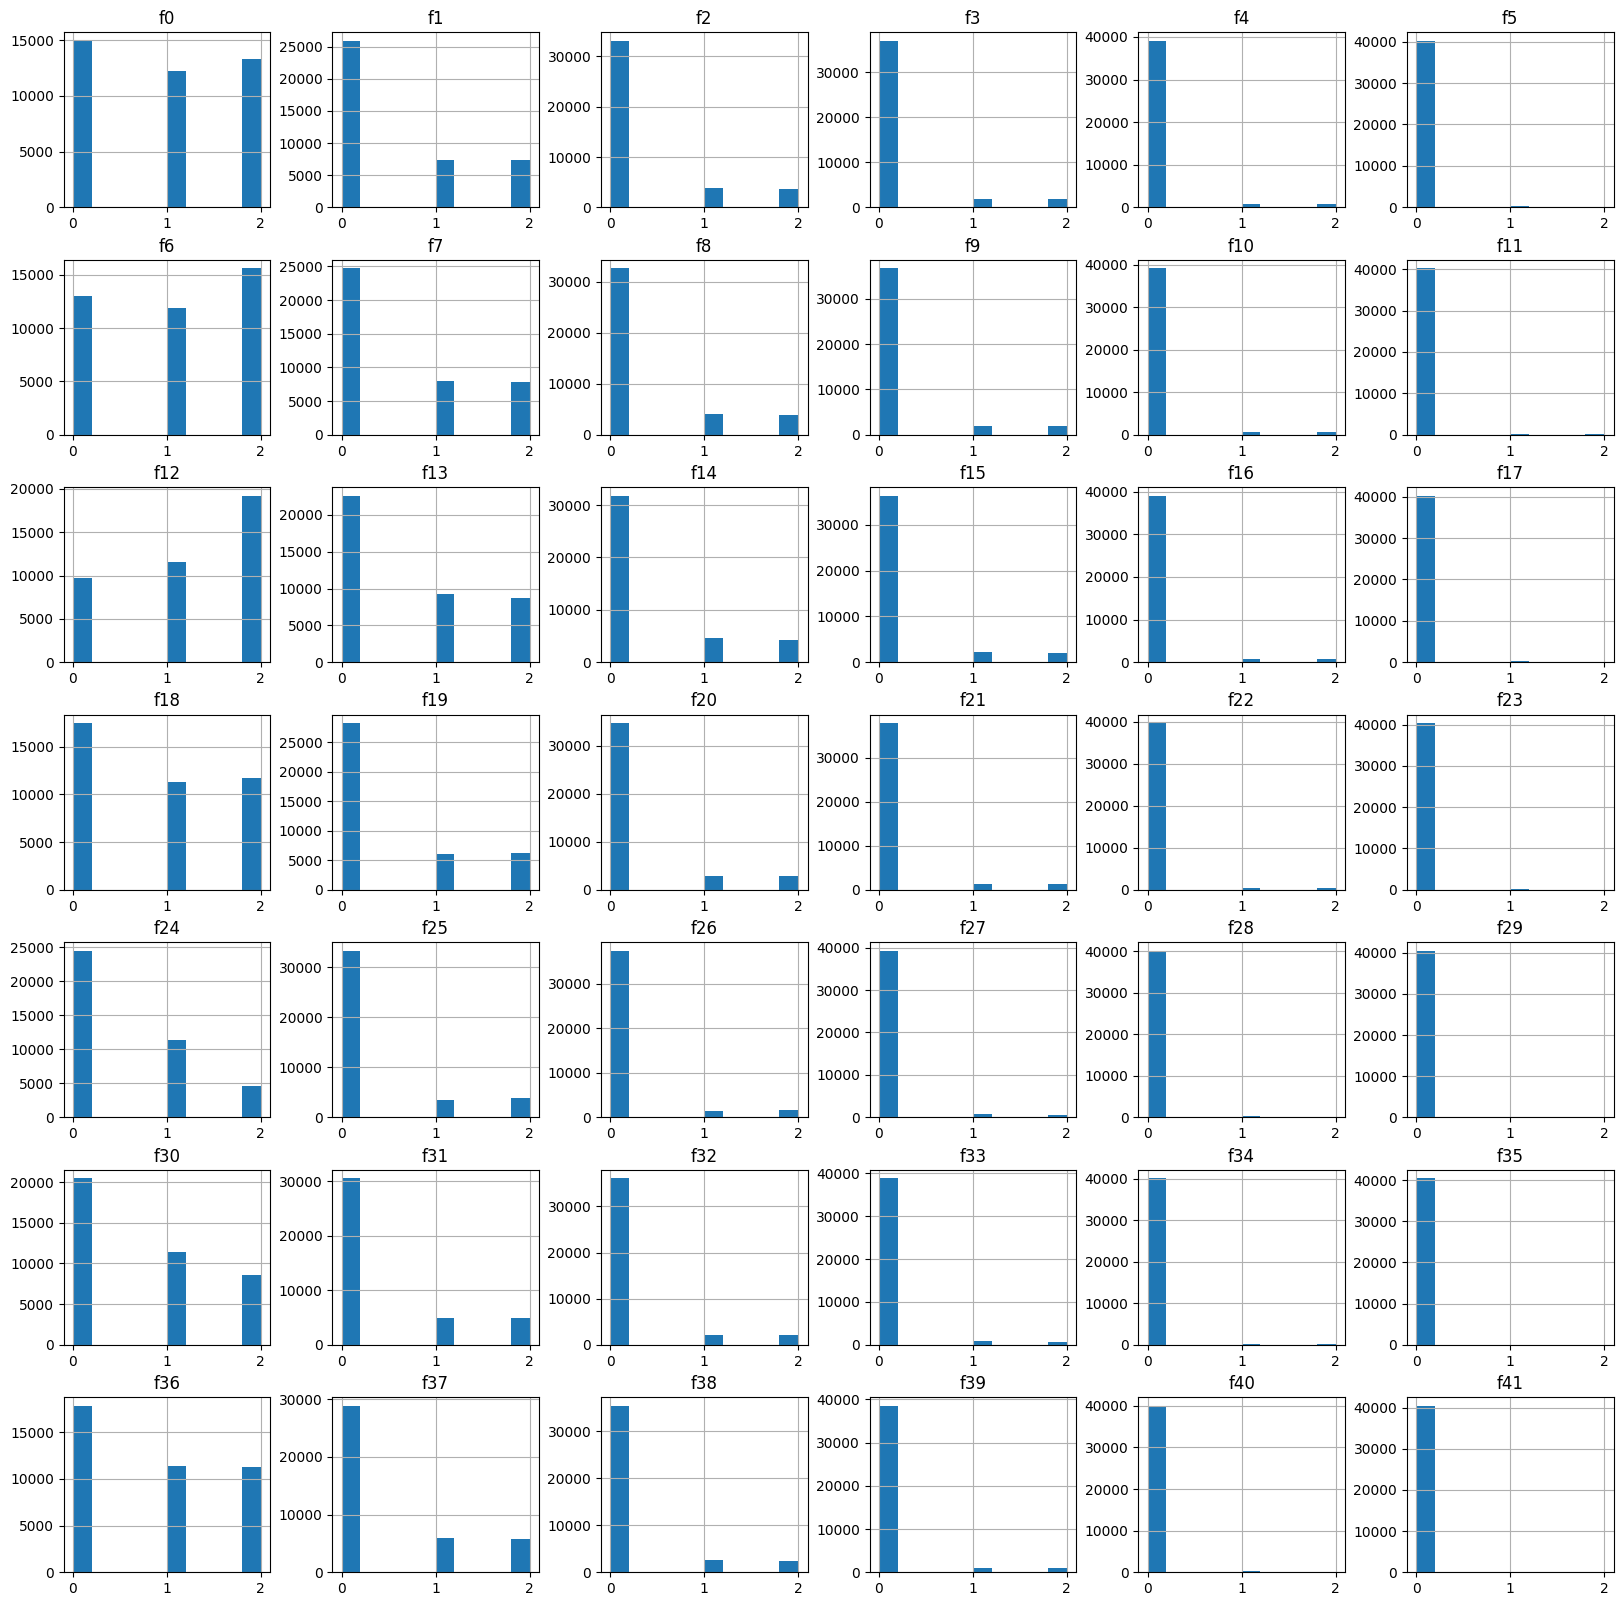

In [84]:
# show the distribution of the features
hist = X_train.hist(figsize=(20, 20))

#### We can see that the distribution of each feature is not uniform, some features are almost always 0, and dont contribute to the model, only increase the size of the dataset, **thus we can reduce them as well.**

# 3. Preprocessing
---
In this section, we will preprocess the data in order to improve the model's performance.
We will do the following:
- Create copies of our datasets and modify them instead of the original ones, to be able to compare results later.
- Remove features that are extremely not correlated with the label.
- Remove features that are almost always 0.

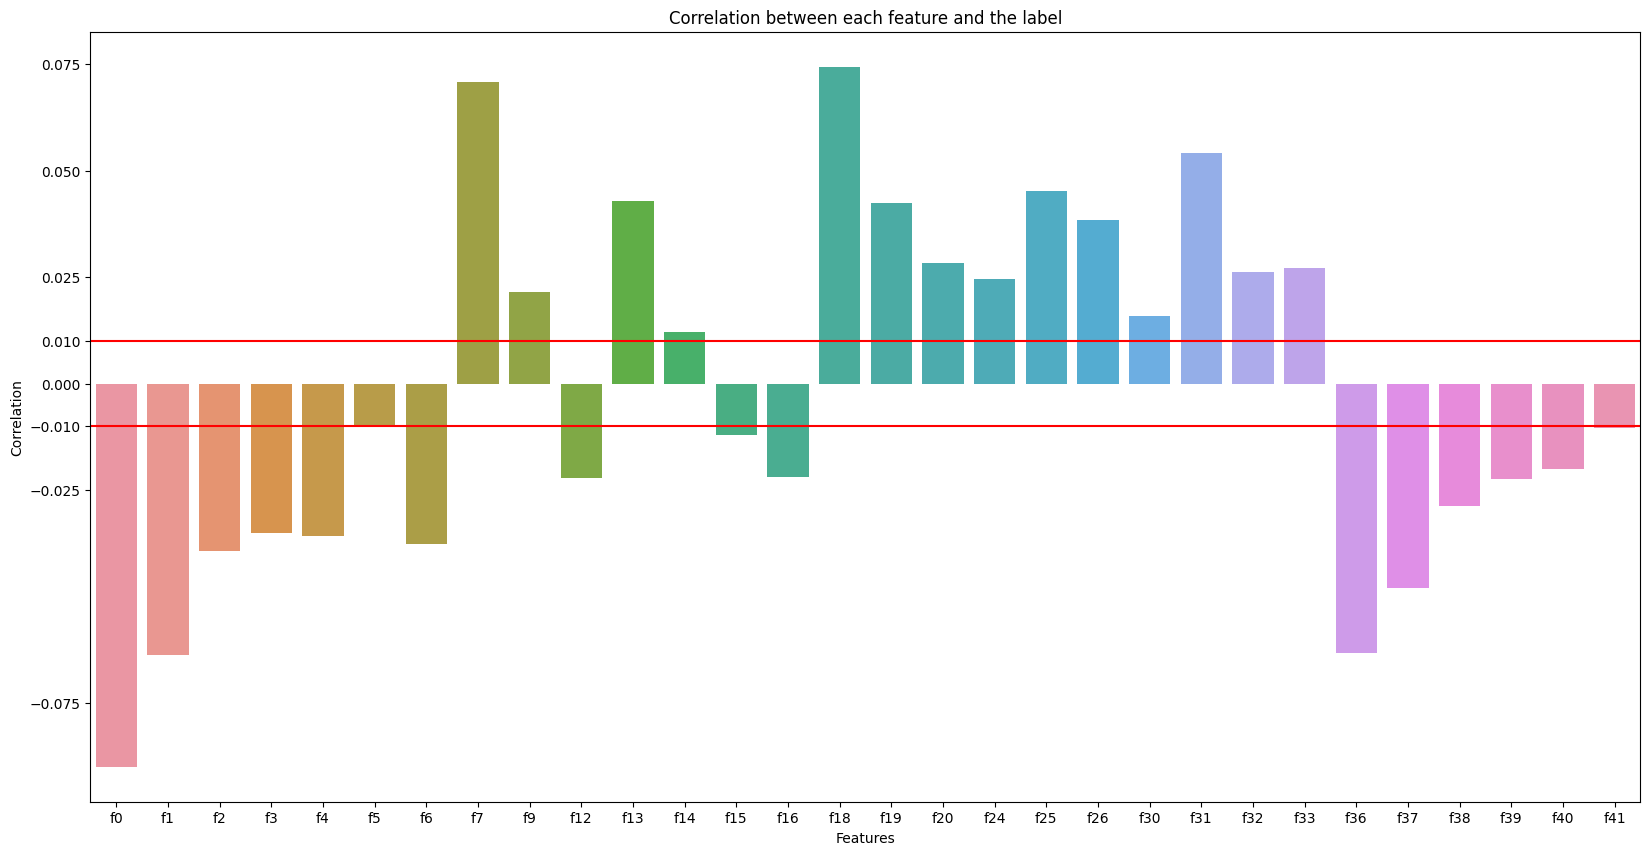

In [85]:
# remove that feature that has a correlation lower than 0.01 and higher than -0.01 with the label
all_correlations = np.array(correlations)
indices = np.where(np.logical_and(all_correlations < 0.01, all_correlations > -0.01))
uncorrelated_feature = X_train.columns[indices]
X_train_modified = X_train.drop(columns=uncorrelated_feature)
X_dev_modified = X_dev.drop(columns=uncorrelated_feature)
X_test_modified = X_test.drop(columns=uncorrelated_feature)
correlations_v2 = plot_feature_label_correlation(X_train_modified, y_train)

In [86]:
# find the indices of the features that are 0 in more than 90% of the samples
indices = np.where(X_train_modified.sum(axis=0) < 0.1 * X_train_modified.shape[0])
# remove those features from the datasets
X_train_modified = X_train_modified.drop(columns=X_train_modified.columns[indices])
X_dev_modified = X_dev_modified.drop(columns=X_dev_modified.columns[indices])
X_test_modified = X_test_modified.drop(columns=X_test_modified.columns[indices])

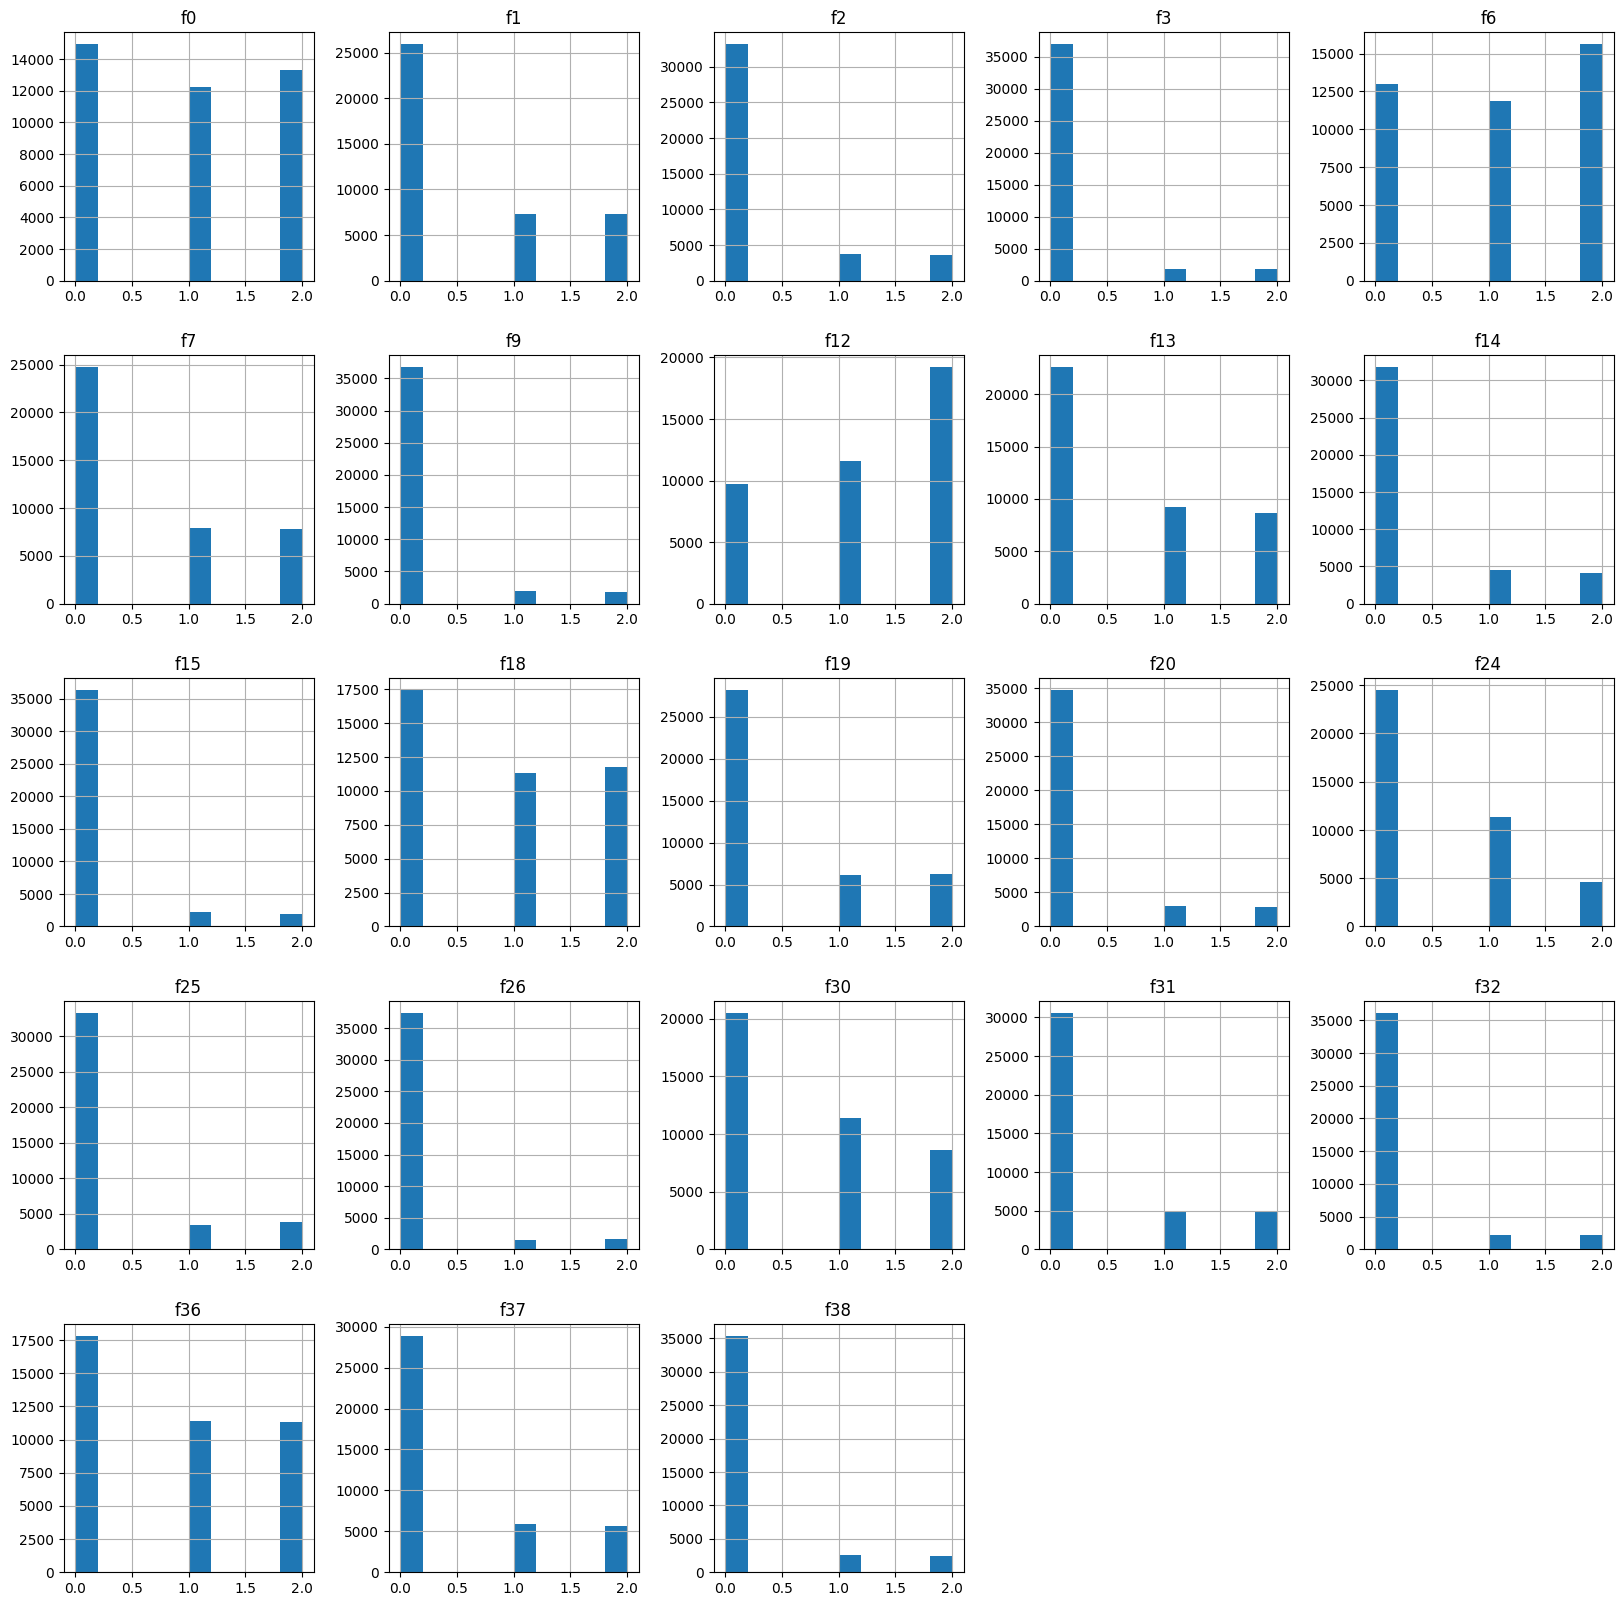

In [87]:
hist_v2 = X_train_modified.hist(figsize=(20, 20))

We are left with significantly fewer features in our modified datasets (23 out of 42), which will hopefully improve the model's performance

# 4. Trying different models on the original datasets
---
In this section, we will try different models on the original datasets, without any modifications to the models and compare their performance.


In [88]:
## defining a helper of kfold on train and dev datasets

def run_k_fold(model,X, y, verbose = True):
  kf = KFold(n_splits=5,shuffle=True)
  accs = []
  for train_index, test_index in kf.split(X.values):
      X_subtrain, X_subtest = X.values[train_index], X.values[test_index]
      y_subtrain, y_subtest = y.values[train_index], y.values[test_index]
      cloned_model = clone(model)
      cloned_model.fit(X_subtrain,y_subtrain)
      acc = accuracy_score(y_subtest, cloned_model.predict(X_subtest))
      accs.append(acc)
  mean_acc = statistics.mean(accs)
  if(verbose):
    print(f"Mean accuracy on the train-dev dataset of {model.__class__.__name__} is {mean_acc}")
  return mean_acc


In [89]:
## function to try several models using kfold
def choose_model_with_k_fold(models_list, X, y, verbose = True):
    all_accs = []
    for model in models_list:
        if(verbose):
          print(f"Trying model: {model.__class__.__name__}")
        acc = run_k_fold(model, X, y, verbose)
        all_accs.append(acc)
        if(verbose):
          print("_________________________________________________________")
    best_acc_model = clone(models_list[np.argmax(all_accs)])
    if(verbose):
      print(f"Best model: {best_acc_model.__class__.__name__}")
    best_acc_model.fit(X, y)
    return best_acc_model

In [90]:
models = [
    DecisionTreeClassifier(),
    LogisticRegression(max_iter=10000),
    GradientBoostingClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    xgb.XGBClassifier()
]

In [91]:
# trying several models using kfold
best_model = choose_model_with_k_fold(models, X_train, y_train)
# check accuracy on dev dataset
y_pred = best_model.predict(X_dev)
score = accuracy_score(y_dev, y_pred)
print(f"Accuracy on dev dataset: {score}")

Trying model: DecisionTreeClassifier
Mean accuracy on the train-dev dataset of DecisionTreeClassifier is 0.7124073188267056
_________________________________________________________
Trying model: LogisticRegression
Mean accuracy on the train-dev dataset of LogisticRegression is 0.6607948293109392
_________________________________________________________
Trying model: GradientBoostingClassifier
Mean accuracy on the train-dev dataset of GradientBoostingClassifier is 0.751289137321997
_________________________________________________________
Trying model: RandomForestClassifier
Mean accuracy on the train-dev dataset of RandomForestClassifier is 0.8011744806867169
_________________________________________________________
Trying model: AdaBoostClassifier
Mean accuracy on the train-dev dataset of AdaBoostClassifier is 0.7269630613807047
_________________________________________________________
Trying model: XGBClassifier
Mean accuracy on the train-dev dataset of XGBClassifier is 0.8270051946

We can see that without any tuning to the models, the best model is the XGBClassifier, with an accuracy of 0.83 on the test dataset.
We will now try to improve the model's performance by balancing the dataset and choosing the best hyperparameters of the model, using the GridSearchCV method.


# 5. Balancing the dataset
---
In this section, we will try to balance the dataset, in order to improve the model's accuracy.

In [92]:
# create a balanced dataset by oversampling the minority classes
sampler = RandomOverSampler(sampling_strategy='not majority')
X_train_balanced, y_train_balanced = sampler.fit_resample(X_train, y_train)

In [93]:
print(f"Distribution of labels in the balanced train dataset, order from most common to least: {list(Counter(y_train_balanced).items())}")

Distribution of labels in the balanced train dataset, order from most common to least: [(2, 26734), (1, 26734), (0, 26734)]


Since we are over sampling the 'train' data, there might be duplications so running a k-fold check might get us unreliable results. thus we will check each model without k-folding.

We will check each model with the over sampled data:

In [94]:
## defining a helper of kfold on train and dev datasets
def predict_model(model, X_train, y_train, X_dev, y_dev, verbose = True):
  model.fit(X_train,y_train)
  acc = accuracy_score(y_dev, model.predict(X_dev))
  if(verbose):
    print(f"Accuracy on the dev dataset of {model.__class__.__name__} is {acc}")
  return acc

## function to try several models
def choose_model(models_list, X_train, y_train, X_dev, y_dev, verbose = True):
    all_accs = []
    trained_models = []
    for model in models_list:
        cloned_model = clone(model)
        if(verbose):
          print(f"Trying model: {model.__class__.__name__}")
        acc = predict_model(cloned_model, X_train, y_train, X_dev, y_dev, verbose)
        all_accs.append(acc)
        trained_models.append(cloned_model)
        if(verbose):
          print("_________________________________________________________")
    
    best_model = trained_models[np.argmax(all_accs)]
    best_acc = np.max(all_accs)
    if(verbose):
      print(f"Best model: {best_model.__class__.__name__}, Accuracy on dev dataset: {best_acc}\n\n")
 
    return (best_model, best_acc)

Now lets check if the accuracy of the models is affected by the balanced dataset.

In [95]:
# trying several models
(best_model_balanced, score) = choose_model(models, X_train_balanced, y_train_balanced, X_dev, y_dev)

Trying model: DecisionTreeClassifier
Accuracy on the dev dataset of DecisionTreeClassifier is 0.7303878034339846
_________________________________________________________
Trying model: LogisticRegression
Accuracy on the dev dataset of LogisticRegression is 0.4456779159265838
_________________________________________________________
Trying model: GradientBoostingClassifier
Accuracy on the dev dataset of GradientBoostingClassifier is 0.650902901124926
_________________________________________________________
Trying model: RandomForestClassifier
Accuracy on the dev dataset of RandomForestClassifier is 0.8084665482534044
_________________________________________________________
Trying model: AdaBoostClassifier
Accuracy on the dev dataset of AdaBoostClassifier is 0.5837773830669035
_________________________________________________________
Trying model: XGBClassifier
Accuracy on the dev dataset of XGBClassifier is 0.7686500888099467
_________________________________________________________
B

We can see that the accuracies of most models are lower, This is a clear indication that using the balanced dataset with this fitting parameter ('not_majority') caused the model to overfit the data.

Now we will try to over sampling with more moderate ratios:

In [96]:
# count the number of samples for each label in the train dataset
print(f"Distribution of labels in the train dataset, ordered from most common to least: {list(Counter(y_train).items())}")

Distribution of labels in the train dataset, ordered from most common to least: [(2, 26734), (1, 9882), (0, 3917)]


In [97]:
zeros_label_count = 3917
ones_label_count = 9882

def tryModelsOverSampling(overSamplingRatio, models):
  print(f"Trying models with overSampling ratio: {overSamplingRatio}")
  # create a balanced dataset by oversampling the minority classes
  sampler = RandomOverSampler(sampling_strategy={0: int(zeros_label_count*overSamplingRatio), 1: int(ones_label_count*overSamplingRatio)},)
  X_train_overSampled, y_train_overSampled = sampler.fit_resample(X_train, y_train)

  # trying several models using kfold
  (best_model_curr_ratio, acc_curr_ratio) = choose_model(models, X_train_overSampled, y_train_overSampled, X_dev, y_dev, verbose = False)
  print(f"Best model: {best_model_curr_ratio.__class__.__name__}, Accuracy on dev dataset: {acc_curr_ratio}\n")


In [98]:
## we will over sample the '0' and '1' labels by each of (1, 1.2, 1.4, 1.6, 1.8). ratio '1' is a control group:
ratios = [1, 1.2, 1.4, 1.6, 1.8]

for ratio in ratios:
  tryModelsOverSampling(ratio, models)

Trying models with overSampling ratio: 1
Best model: XGBClassifier, Accuracy on dev dataset: 0.8335553582001184

Trying models with overSampling ratio: 1.2
Best model: XGBClassifier, Accuracy on dev dataset: 0.8345914742451155

Trying models with overSampling ratio: 1.4
Best model: XGBClassifier, Accuracy on dev dataset: 0.8337033747779752

Trying models with overSampling ratio: 1.6
Best model: XGBClassifier, Accuracy on dev dataset: 0.8317791592658378

Trying models with overSampling ratio: 1.8
Best model: XGBClassifier, Accuracy on dev dataset: 0.826080521018354



# 6.Choosing the best hyperparameters for the XGBClassifier
---
In this section, we will use the GridSearchCV method to find the best hyperparameters for the XGBClassifier model.
Although this method is very time-consuming, we will perform it on our modified datasets, which have fewer features, in order to reduce the time it takes to run.
First, we need to make sure the accuracy of the models is not affected by the reduced number of features, so we will run the same models as before, but on the modified datasets.

In [99]:
best_model_modified = choose_model_with_k_fold(models, X_train_modified, y_train)
y_pred = best_model_modified.predict(X_dev_modified)
score = accuracy_score(y_dev, y_pred)
print(f"Accuracy on test dataset: {score}")

Trying model: DecisionTreeClassifier
Mean accuracy on the train-dev dataset of DecisionTreeClassifier is 0.695137327292613
_________________________________________________________
Trying model: LogisticRegression
Mean accuracy on the train-dev dataset of LogisticRegression is 0.6609186329731039
_________________________________________________________
Trying model: GradientBoostingClassifier
Mean accuracy on the train-dev dataset of GradientBoostingClassifier is 0.7452446401328932
_________________________________________________________
Trying model: RandomForestClassifier
Mean accuracy on the train-dev dataset of RandomForestClassifier is 0.7799571278195585
_________________________________________________________
Trying model: AdaBoostClassifier
Mean accuracy on the train-dev dataset of AdaBoostClassifier is 0.7245699885424015
_________________________________________________________
Trying model: XGBClassifier
Mean accuracy on the train-dev dataset of XGBClassifier is 0.8160264250

We can see that the accuracy of the models is not significantly affected by the reduced number of features, so we can proceed to the next step.

In [100]:
# perform grid search on the best model XGBClassifier
def grid_search_wrapper(model, X_train, y_train, param_grid, X_dev, y_dev):
    clf = GridSearchCV(model, param_grid, n_jobs=5, cv=5, verbose=2, refit=True)
    clf.fit(X_train, y_train)
    print(f"Best parameters for {model.__class__.__name__}: \n{clf.best_params_} \nwith score: {clf.best_score_}")
    y_pred = clf.predict(X_dev)
    score = accuracy_score(y_dev, y_pred)
    print(f"Accuracy on dev dataset after grid search for the hyper parameters: {score}")
    return clf.best_estimator_

In [101]:
# create a parameter grid for the XGBClassifier with the most important hyperparameters
parameters = {
    'max_depth': [10,11,12,13,14],
    'alpha': [3,4,5,6,7,8],
    'reg_lambda': [3,4,5,6,7],
    "eta" : [0.6, 0.7, 0.8, 0.9, 1]
}

best_model = grid_search_wrapper(xgb.XGBClassifier(), X_train_modified, y_train, parameters, X_dev_modified, y_dev)

Fitting 5 folds for each of 750 candidates, totalling 3750 fits


KeyboardInterrupt: ignored

This function runtime is very long, we will insert the output values of the hyper parameters manually

In [102]:
classifier = xgb.XGBClassifier(max_depth= 12, alpha= 3, reg_lambda= 6, eta= 0.7) #best hyper parameters

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_dev)
score = accuracy_score(y_dev, y_pred)
print(f"Accuracy on dev dataset: {score}")

Accuracy on dev dataset: 0.8574600355239786


# 7.Conclusion
---
In this section, we will consolidate the insights gained from each component and leverage the preprocessed data to build an optimized "best" model.
In order to get better results - we will fit the model on the concatenate of the train and the dev datasets.



In [103]:
# union modified dev and train datasets
X_trainDev_modified = pd.concat([X_train_modified, X_dev_modified], axis=0)
y_trainDev = pd.concat([y_train, y_dev], axis=0)

## using XGB- the best model we found in section 4 and the best hyper parameters from section 6
classifier = xgb.XGBClassifier(max_depth= 12, alpha= 3, reg_lambda= 6, eta= 0.7)

classifier.fit(X_trainDev_modified, y_trainDev)
y_pred = classifier.predict(X_test_modified)
score = accuracy_score(y_test, y_pred)
print(f"Accuracy on test dataset with the modified data and the best hyper parameters: {score}")

Accuracy on test dataset with the modified data and the best hyper parameters: 0.8328892835997632


In [ ]:
#DELETE
iterNum=1
bestAcc = 0
import itertools
etas = [0.6, 0.7, 0.8, 0.9, 1]
max_depths = [10,11,12,13,14]
alphas = [3,4,5,6,7,8]
reg_lambdas = [3,4,5,6,7]
ratios_label0 = [1]
ratios_label1 = [1]
label0_size = 5200
label1_size = 12000
for eta, max_depth, alpha, reg_lambda, ratio_label0, ratio_label1 in itertools.product(etas, max_depths, alphas, reg_lambdas, ratios_label0, ratios_label1):
    Xgb = xgb.XGBClassifier(eta=eta, max_depth=max_depth, alpha=alpha, reg_lambda=reg_lambda)
    Xgb.fit(X_trainDev_modified, y_trainDev)
    xgb_pred = Xgb.predict(X_test_modified)
    acc = accuracy_score(y_test, xgb_pred)
    if(acc > bestAcc):
      bestAcc = acc
      bestParameters = {
        "eta": eta,
        "max_depth": max_depth,
        "alpha": alpha,
        "reg_lambda": reg_lambda,
        "ratio_label0": ratio_label0,
        "ratio_label1": ratio_label1
      }
      print(f'Got a better score: {acc}, parameters: {bestParameters}, Iterartion number: {iterNum}')
    if(iterNum % 5 == 0):
      print(f'Iterartion number: {iterNum}, best score until now: {bestAcc}')
    iterNum += 1

Got a better score: 0.8349615156897573, parameters: {'eta': 0.6, 'max_depth': 10, 'alpha': 3, 'reg_lambda': 3, 'ratio_label0': 1, 'ratio_label1': 1}, Iterartion number: 1
Got a better score: 0.8353315571343991, parameters: {'eta': 0.6, 'max_depth': 10, 'alpha': 3, 'reg_lambda': 4, 'ratio_label0': 1, 'ratio_label1': 1}, Iterartion number: 2
Got a better score: 0.8354055654233274, parameters: {'eta': 0.6, 'max_depth': 10, 'alpha': 3, 'reg_lambda': 6, 'ratio_label0': 1, 'ratio_label1': 1}, Iterartion number: 4
Iterartion number: 5, best score until now: 0.8354055654233274
Got a better score: 0.8358496151568976, parameters: {'eta': 0.6, 'max_depth': 10, 'alpha': 4, 'reg_lambda': 3, 'ratio_label0': 1, 'ratio_label1': 1}, Iterartion number: 6
Got a better score: 0.8361456483126111, parameters: {'eta': 0.6, 'max_depth': 10, 'alpha': 4, 'reg_lambda': 7, 'ratio_label0': 1, 'ratio_label1': 1}, Iterartion number: 10
Iterartion number: 10, best score until now: 0.8361456483126111
Iterartion number